ПО ОТДЕЛЬНСОТИ КАЖДАЯ МОДЕЛЬ CIFIR 10!!!!

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 1 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.65it/s]


Test Accuracy without Cholesky: 45.81%
Test Accuracy with Cholesky: 44.72%


Epoch 2 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.73it/s]


Test Accuracy without Cholesky: 50.59%
Test Accuracy with Cholesky: 49.99%


Epoch 3 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.71it/s]


Test Accuracy without Cholesky: 54.31%
Test Accuracy with Cholesky: 55.65%


Epoch 4 Training (with Cholesky): 100%|██████████| 782/782 [00:27<00:00, 28.38it/s]


Test Accuracy without Cholesky: 57.34%
Test Accuracy with Cholesky: 57.47%


Epoch 5 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.62it/s]


Test Accuracy without Cholesky: 59.75%
Test Accuracy with Cholesky: 59.42%


Epoch 6 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.44it/s]


Test Accuracy without Cholesky: 61.29%
Test Accuracy with Cholesky: 60.62%


Epoch 7 Training (with Cholesky): 100%|██████████| 782/782 [00:25<00:00, 30.64it/s]


Test Accuracy without Cholesky: 61.91%
Test Accuracy with Cholesky: 62.15%


Epoch 8 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.68it/s]


Test Accuracy without Cholesky: 63.32%
Test Accuracy with Cholesky: 63.43%


Epoch 9 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.72it/s]


Test Accuracy without Cholesky: 64.97%
Test Accuracy with Cholesky: 64.19%


Epoch 10 Training (with Cholesky): 100%|██████████| 782/782 [00:24<00:00, 31.94it/s]


Test Accuracy without Cholesky: 64.72%
Test Accuracy with Cholesky: 62.81%

--- Summary of Results ---
Total Time (without Cholesky): 250.12 seconds
Total Memory (without Cholesky): -57498624 bytes
Average Accuracy (without Cholesky): 58.40%
Total Time (with Cholesky): 250.57 seconds
Total Memory (with Cholesky): 26631168 bytes
Average Accuracy (with Cholesky): 58.05%


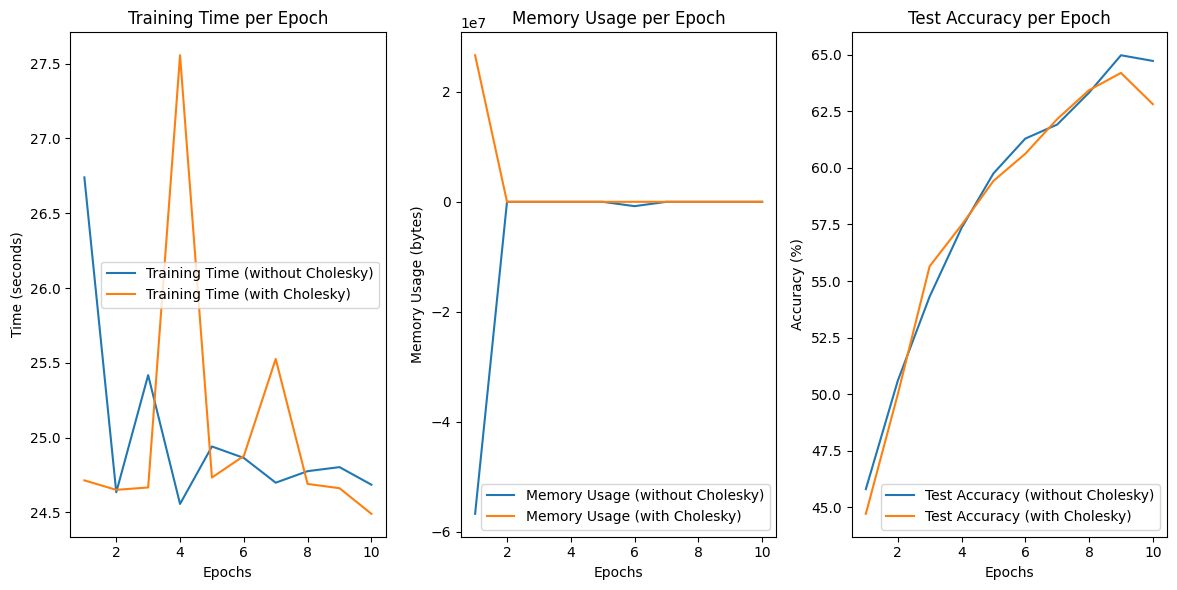

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer block with Cholesky decomposition
class TransformerBlockCholesky(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.cholesky_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        # Apply attention and compute score matrix for Cholesky decomposition
        attn_output, attn_weights = self.attn(x2, x2, x2)  # Self-attention
        if self.cholesky_factor is None:
            self.cholesky_factor = self._cholesky_decomposition(attn_weights)
        x = x + attn_output  # Add attention output to input (residual connection)
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _cholesky_decomposition(self, x):
        # Apply Cholesky decomposition to attention score matrix (x)
        L = torch.linalg.cholesky(x)  # Cholesky decomposition
        return L

# Main model with Cholesky blocks and Positional Encoding
class CustomVisionTransformerCholesky(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockCholesky(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Testing the Cholesky decomposition
def test_cholesky(x):
    attn_matrix = torch.matmul(x, x.transpose(-2, -1))
    L = torch.linalg.cholesky(attn_matrix)
    return L

# Initialize models and optimizers
model = CustomVisionTransformerCholesky(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times, train_memories, test_accuracies = [], [], []

# Load and prepare data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training the model with Cholesky
for epoch in range(10):
    model.train()
    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()

    train_times.append(epoch_end_time - epoch_start_time)
    train_memories.append(epoch_end_mem - epoch_start_mem)

    # Test accuracy for model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            total += labels.size(0)

    test_accuracy = correct / total * 100
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy (with Cholesky): {test_accuracy:.2f}%")

# Print summary of results
print("\n--- Summary of Results ---")
print(f"Total Time: {sum(train_times):.2f} seconds")
print(f"Total Memory: {sum(train_memories)} bytes")
print(f"Average Accuracy: {sum(test_accuracies) / len(test_accuracies):.2f}%")

# Plotting results
plt.figure(figsize=(12, 6))

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_times, label="Training Time")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_memories, label="Memory Usage")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), test_accuracies, label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

SVD1

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 1 Training SVD: 100%|██████████| 782/782 [01:23<00:00,  9.33it/s]


Test Accuracy with SVD: 44.74%


Epoch 1 Training No SVD: 100%|██████████| 782/782 [00:26<00:00, 29.96it/s]


Test Accuracy without SVD: 45.21%


Epoch 2 Training SVD: 100%|██████████| 782/782 [01:22<00:00,  9.52it/s]


Test Accuracy with SVD: 51.74%


Epoch 2 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.37it/s]


Test Accuracy without SVD: 50.05%


Epoch 3 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.55it/s]


Test Accuracy with SVD: 54.07%


Epoch 3 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.33it/s]


Test Accuracy without SVD: 55.16%


Epoch 4 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.56it/s]


Test Accuracy with SVD: 57.19%


Epoch 4 Training No SVD: 100%|██████████| 782/782 [00:26<00:00, 29.63it/s]


Test Accuracy without SVD: 58.24%


Epoch 5 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.58it/s]


Test Accuracy with SVD: 59.65%


Epoch 5 Training No SVD: 100%|██████████| 782/782 [00:25<00:00, 30.54it/s]


Test Accuracy without SVD: 59.82%


Epoch 6 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.54it/s]


Test Accuracy with SVD: 61.04%


Epoch 6 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.74it/s]


Test Accuracy without SVD: 61.33%


Epoch 7 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.59it/s]


Test Accuracy with SVD: 62.10%


Epoch 7 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.55it/s]


Test Accuracy without SVD: 62.91%


Epoch 8 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.59it/s]


Test Accuracy with SVD: 64.21%


Epoch 8 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.91it/s]


Test Accuracy without SVD: 62.03%


Epoch 9 Training SVD: 100%|██████████| 782/782 [01:21<00:00,  9.60it/s]


Test Accuracy with SVD: 64.23%


Epoch 9 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.99it/s]


Test Accuracy without SVD: 63.42%


Epoch 10 Training SVD: 100%|██████████| 782/782 [01:22<00:00,  9.49it/s]


Test Accuracy with SVD: 64.58%


Epoch 10 Training No SVD: 100%|██████████| 782/782 [00:24<00:00, 31.96it/s]


Test Accuracy without SVD: 63.79%

--- Summary of Results ---
Total Time (with SVD): 820.31 seconds
Total Memory (with SVD): 10681856 bytes
Average Accuracy (with SVD): 58.36%
Total Time (without SVD): 250.91 seconds
Total Memory (without SVD): 59849728 bytes
Average Accuracy (without SVD): 58.20%


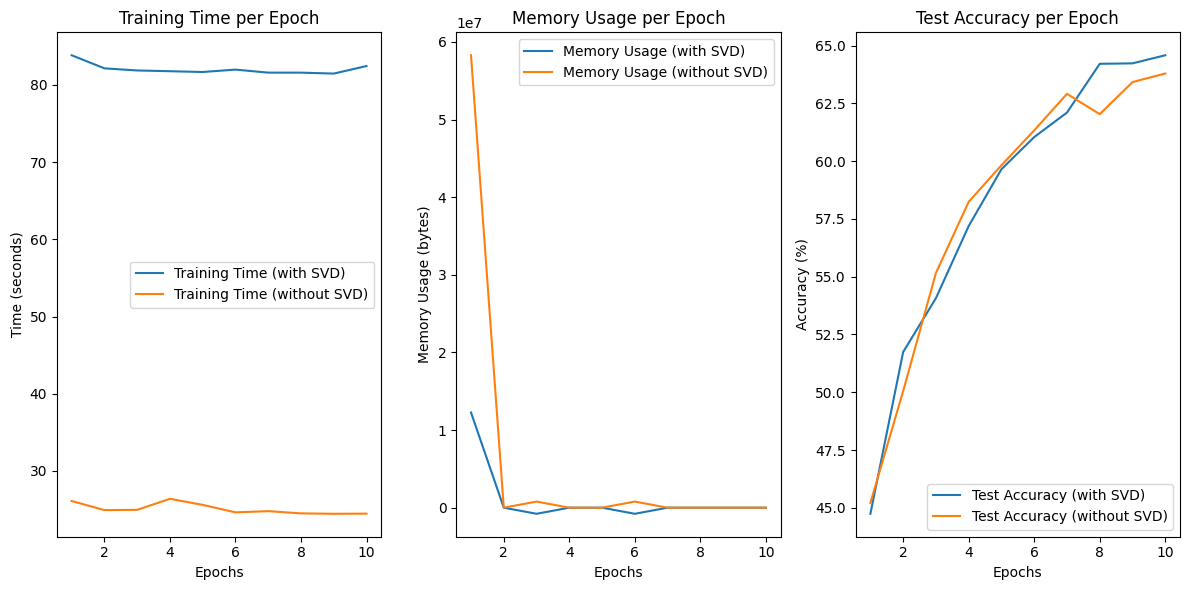

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with SVD decomposition
class TransformerBlockSVD(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.svd_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)  # Self-attention
        attn_output = self._svd_decomposition(attn_output)
        x = x + attn_output  # Adding the SVD-decoded attention output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _svd_decomposition(self, attn_output):
        # Apply SVD to the attention output
        batch_size, seq_len, embed_dim = attn_output.size()

        # Flatten for SVD computation
        attn_matrix = attn_output.view(batch_size * seq_len, embed_dim)

        # Perform SVD
        U, S, V = torch.svd(attn_matrix)  # SVD decomposition
        S = torch.diag(S)  # Create diagonal matrix for singular values
        attn_output_reduced = torch.matmul(U, torch.matmul(S, V.T))

        # Reshape back to the attention output shape
        attn_output_reduced = attn_output_reduced.view(batch_size, seq_len, embed_dim)
        return attn_output_reduced

# Transformer block without SVD
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)  # Self-attention
        x = x + attn_output  # Adding attention output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

# Model with SVD blocks
class CustomVisionTransformerSVD(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockSVD(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without SVD blocks
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model_svd = CustomVisionTransformerSVD(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)
model_no_svd = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)

optimizer_svd = torch.optim.Adam(model_svd.parameters(), lr=1e-4)
optimizer_no_svd = torch.optim.Adam(model_no_svd.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_svd, train_memories_svd, test_accuracies_svd = [], [], []
train_times_no_svd, train_memories_no_svd, test_accuracies_no_svd = [], [], []

# Training model with SVD
for epoch in range(10):
    # Train with SVD
    model_svd.train()
    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training SVD"):
        images, labels = images.to(device), labels.to(device)
        optimizer_svd.zero_grad()
        outputs = model_svd(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_svd.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()
    train_times_svd.append(epoch_end_time - epoch_start_time)
    train_memories_svd.append(epoch_end_mem - epoch_start_mem)

    # Test model with SVD
    model_svd.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc=f"Epoch {epoch + 1} Testing SVD"):
            images, labels = images.to(device), labels.to(device)
            outputs = model_svd(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracies_svd.append(test_accuracy)
    print(f"Epoch {epoch + 1} Test Accuracy SVD: {test_accuracy:.4f}")

# Training model without SVD
for epoch in range(10):
    # Train without SVD
    model_no_svd.train()
    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training No SVD"):
        images, labels = images.to(device), labels.to(device)
        optimizer_no_svd.zero_grad()
        outputs = model_no_svd(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_no_svd.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()
    train_times_no_svd.append(epoch_end_time - epoch_start_time)
    train_memories_no_svd.append(epoch_end_mem - epoch_start_mem)

    # Test model without SVD
    model_no_svd.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc=f"Epoch {epoch + 1} Testing No SVD"):
            images, labels = images.to(device), labels.to(device)
            outputs = model_no_svd(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracies_no_svd.append(test_accuracy)
    print(f"Epoch {epoch + 1} Test Accuracy No SVD: {test_accuracy:.4f}")

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_times_svd, label="Training Time (with SVD)")
plt.plot(range(1, 11), train_times_no_svd, label="Training Time (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_memories_svd, label="Memory Usage (with SVD)")
plt.plot(range(1, 11), train_memories_no_svd, label="Memory Usage (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), test_accuracies_svd, label="Test Accuracy (with SVD)")
plt.plot(range(1, 11), test_accuracies_no_svd, label="Test Accuracy (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### PCA


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 10 Training (with PCA): 100%|██████████| 782/782 [00:25<00:00, 30.53it/s]



--- Summary of Results ---
Average Training Time (without PCA): 25.85 seconds/epoch
Average Memory Usage (without PCA): -5651302.40 MB/epoch
Average Test Accuracy (without PCA): 58.48%
Average Training Time (with PCA): 26.00 seconds/epoch
Average Memory Usage (with PCA): 1757952.00 MB/epoch
Average Test Accuracy (with PCA): 58.21%


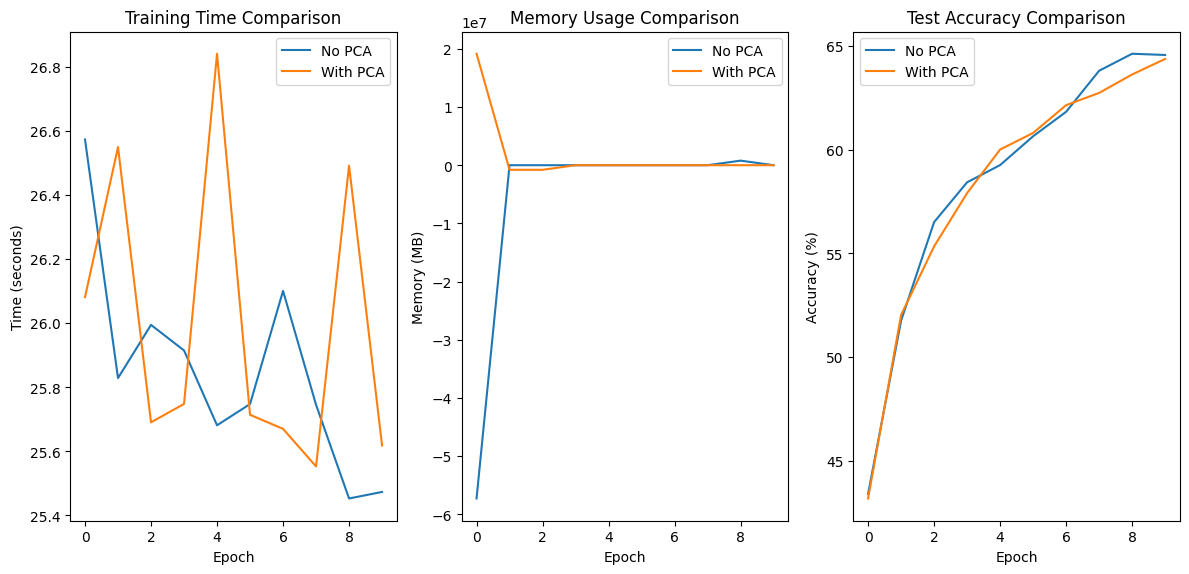

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import math
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with PCA-based low-rank approximation
class TransformerBlockPCA(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using PCA

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def pca_low_rank_approximation(self, attn_matrix):
        # Apply PCA with truncation for low-rank approximation
        pca = PCA(n_components=self.rank)
        attn_matrix = attn_matrix.cpu().numpy()  # Convert tensor to numpy
        attn_matrix_pca = pca.fit_transform(attn_matrix)  # Perform PCA
        attn_matrix_low_rank = pca.inverse_transform(attn_matrix_pca)  # Inverse transform to get low-rank approximation
        return torch.tensor(attn_matrix_low_rank).to(attn_matrix.device)  # Convert back to tensor

# Positional encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x should have shape [batch_size, seq_len, embed_dim]
        return x + self.pe[:, :x.size(1)]

# Main model with PCA-based low-rank approximation blocks and positional encoding
class CustomVisionTransformerPCA(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=(img_size // patch_size) ** 2)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding to the embedded patches

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without PCA-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=(img_size // patch_size) ** 2)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding to the embedded patches

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# The rest of the code remains the same for training and evaluation


# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)
model_pca = CustomVisionTransformerPCA(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_pca = torch.optim.Adam(model_pca.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_pca, train_times_with_pca = [], []
train_memories_no_pca, train_memories_with_pca = [], []
test_accuracies_no_pca, test_accuracies_with_pca = [], []

# Training models
for epoch in range(10):
    # Train model without PCA
    model.train()
    epoch_start_time_no_pca = time.time()
    epoch_start_mem_no_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_pca = time.time()
    epoch_end_mem_no_pca = get_memory_usage()

    train_times_no_pca.append(epoch_end_time_no_pca - epoch_start_time_no_pca)
    train_memories_no_pca.append(epoch_end_mem_no_pca - epoch_start_mem_no_pca)

    # Test accuracy for model without PCA
    model.eval()
    correct_no_pca, total_no_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_pca += (predicted == labels).sum().item()

            total_no_pca += labels.size(0)

    test_accuracy_no_pca = correct_no_pca / total_no_pca * 100
    test_accuracies_no_pca.append(test_accuracy_no_pca)

    # Train model with PCA
    model_pca.train()
    epoch_start_time_with_pca = time.time()
    epoch_start_mem_with_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer_pca.zero_grad()
        outputs_pca = model_pca(images)
        loss_pca = loss_fn(outputs_pca, labels)
        loss_pca.backward()
        optimizer_pca.step()

    epoch_end_time_with_pca = time.time()
    epoch_end_mem_with_pca = get_memory_usage()

    train_times_with_pca.append(epoch_end_time_with_pca - epoch_start_time_with_pca)
    train_memories_with_pca.append(epoch_end_mem_with_pca - epoch_start_mem_with_pca)

    # Test accuracy for model with PCA
    model_pca.eval()
    correct_with_pca, total_with_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs_pca = model_pca(images)
            _, predicted = torch.max(outputs_pca, 1)
            correct_with_pca += (predicted == labels).sum().item()

            total_with_pca += labels.size(0)

    test_accuracy_with_pca = correct_with_pca / total_with_pca * 100
    test_accuracies_with_pca.append(test_accuracy_with_pca)

# Print summarized results
print("\n--- Summary of Results ---")
print(f"Average Training Time (without PCA): {sum(train_times_no_pca) / len(train_times_no_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (without PCA): {sum(train_memories_no_pca) / len(train_memories_no_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (without PCA): {sum(test_accuracies_no_pca) / len(test_accuracies_no_pca):.2f}%")

print(f"Average Training Time (with PCA): {sum(train_times_with_pca) / len(train_times_with_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (with PCA): {sum(train_memories_with_pca) / len(train_memories_with_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (with PCA): {sum(test_accuracies_with_pca) / len(test_accuracies_with_pca):.2f}%")

# Plot results
plt.figure(figsize=(12, 6))

# Training time comparison
plt.subplot(1, 3, 1)
plt.plot(train_times_no_pca, label="No PCA")
plt.plot(train_times_with_pca, label="With PCA")
plt.title("Training Time Comparison")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.legend()

# Memory usage comparison
plt.subplot(1, 3, 2)
plt.plot(train_memories_no_pca, label="No PCA")
plt.plot(train_memories_with_pca, label="With PCA")
plt.title("Memory Usage Comparison")
plt.xlabel("Epoch")
plt.ylabel("Memory (MB)")
plt.legend()

# Accuracy comparison
plt.subplot(1, 3, 3)
plt.plot(test_accuracies_no_pca, label="No PCA")
plt.plot(test_accuracies_with_pca, label="With PCA")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()